# A runtime comparison of HDBSCAN\* and DBSCAN
In this notebook we will attempt an apples to apples comparison between our python implementation of HDBSCAN\* and sklearns implementation of DBSCAN.  It should be considered supplemental material to the paper: 
Accelerated Hierarchical Density Clustering by McInnes and Healy.  A reader should examine that paper for a more detailed examination of the algorithms in question.  

As detailed in Campello, Moulavi and Sander 2013 paper ""Density-Based Clustering Based on Hierarchical Density Estimates"" HDBSCAN can be thought of as first computing DBSCAN for all values of epsilon and composing these results into a hierarchical dendrogram.  Then taking a variable height cut through this dendrogram so as to maximize the persistence of clusters.  The similarity of these algorithms begs a side by side comparision of their performance.  In this notebooks we will not attempt to perform such an analysis to help provide some insite into the effects of data on the run time performance of these algorithms.

Like all tree based algorithms run time and run time complexity are data dependent.  As indicated in \cite{} this raises significant difficulties when benchmarking algorithms or implementations.  Our interest is in demonstrating the comparability of scaling performance for these algorithms under the assumption both algorithms being tree based they should have similar performance changes under different data distributions.  As such, we will examine the run time behaviour of both algorithms with respect to a fairly simple data set.  

One major difficulty with an examination of DBSCAN run time performance with default perameters is that very small values of $\varepsilon$ will return few or no core points which results in very fast timings with virually all the data being relagated to background noise.  To circuvent this problem and we will perform a search over the parameter space of DBSCAN in order to find the paramaters which best match our HDBSCAN\* results on a particular data set.  Then we will benchmark the training of a DBSCAN model with those specific parameters.  Though, in practice, a user may not know the optimal parameter values for DBSCAN we will exclude that from this experiment.  For this simple scaling experiment our data will consist of mixtures of a gaussian distributions laid down within a fixed diameter box.  We use varible numbers of fixed variance gaussian balls for simplicity and to not unfairly penalize DBSCAN.  We are interested in run time analysis here not the ability to fit varying density clusters.  We vary dimension, number of clusters and number of data points to determine their effect on run time.

Our paremter search will be conducted using gaussian process optimization.  The adjusted rand index between DBSCAN clusterings and a pre-established HDBSCAN\* clustering will be used as the objective function to be maximized.  

 We make use of sklearns make_blobs function for generatig this data.



In [1]:
#Data handling and exploration
import pandas as pd
import numpy as np
#Clustering and visualization
import sklearn.datasets
import sklearn.cluster
import sklearn.manifold
import sklearn.metrics
import hdbscan
import time
from timeit import default_timer as timer
import skopt
from skopt import gp_minimize

from scipy import stats


#Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_color_codes()

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import pkg_resources
print('hdbscan version: {}'.format(pkg_resources.get_distribution("hdbscan").version))
print('pandas version: {}'.format(pkg_resources.get_distribution("pandas").version))
print('skopt version: {}'.format(pkg_resources.get_distribution("skopt").version))
print('sklearn version: {}'.format(pkg_resources.get_distribution("scikit-learn").version))

hdbscan version: 0.8.7
pandas version: 0.19.2
skopt version: 0.1
sklearn version: 0.18.1


In [4]:
def best_dbscan(data, labels, cluster_metric='adjusted_rand',eps=None, min_samples=None, metric='euclidean'):
    """Performs a hyperparameter search of the dbscan space to find the paramters which
    generate the most similar clustering to labels via the defined metric
    min_samples: either a tuple of the form (min_min_samples, max_min_samples)
                 or a list of values to search over.
                 default: (1, 2*hdbscan_min_samples)
                 here hdbscan_min_samples is passed in as a global
    eps: either a tuple of the form (min_eps, max_eps)
                 or a list of values to search over.
                 default: (0.01, max distance to the max_min_samples nearest neighbour)
    metric: <string> any metric supported by DBSCAN.  default: 'euclidean'
    """

    # Doesn't currently handle the case of eps without a min_samples
    if((eps is None) and (min_samples is not None)):
        raise ValueError('Please set either both or neither of eps and min_samples')
  

    if(min_samples is None):
        smallestMinSamples = 1
        largestMinSamples = 2* hdbscan_min_samples
        min_samples = (smallestMinSamples, largestMinSamples)

  
    if(eps is None):
        smallestEpsilon = 0.01
        # Now we'll find the largest distance to the largestMinSamples nearest neighbour
        kdtree = sklearn.neighbors.KDTree(data)
        k = min(data.shape[0], largestMinSamples)
        largestEpsilon = np.max(kdtree.query(data,k=k)[0][:,-1])
        eps = (smallestEpsilon, largestEpsilon)
        
    space = [eps, # epsilon
             min_samples   #min_samples
            ]
         
    cluster_model = sklearn.cluster.DBSCAN()
    #labels previously constructed via hdbscan
    #probably should pass this in
    def objective(params):
        """In a fit of poor programming labels, cluster_model and data are passed into this function 
        as global parameters
        """
        eps, min_samples = params
        cluster_model.set_params(eps=eps, min_samples=min_samples, metric=metric)
        dbscan_labels = cluster_model.fit_predict(data)
        return(-1*sklearn.metrics.adjusted_rand_score(labels, dbscan_labels)) 

    res_gp = gp_minimize(objective, space, n_calls=100, n_jobs=-1)
   
    return(res_gp)  


## Specify the parameter range over which to search

In [5]:
#sizes=[500,5000,50000]
replications = list(range(0,10))
sizes = [1000*2**i for i in range(0,10)]
#sizes = [1000*(2**i) for i in list(range(0,3))]
dimensions = [2,10,50]
clusters = [2,10,50]
combinations = len(sizes)*len(dimensions)*len(clusters)*len(replications)
results = pd.DataFrame(np.nan, index=list(range(0,combinations)), 
                       columns=['size','dimension', 'clusters', 'rep', 'hdbscan_time', 'dbscan_time','adjusted_rand',
                                'hdbscan_min_samples', 'hdbscan_min_cluster_size', 
                                'dbscan_epsilon', 'dbscan_min_samples'])

In [6]:
"Testing {} data set combinations".format(combinations)

'Testing 900 data set combinations'

## Optimal parameter search
This search can be quite computationally expensive to perform.  It was computed in parallel across a large memory multi-core system and the results of the optimization exported to a file.  We make use of gaussian process optimization to find the set of dbscan parameters which best match our hdbscan cluster results.

In [7]:
if(False):
    #Build data (blobs for now)
    counter = 0
    hdbscan_min_samples =15 
    hdbscan_min_cluster_size = 10

    for rep in replications:
        for size in sizes:
            for dataset_dimension in dimensions:
                for dataset_n_clusters in clusters:
                    process_timer = timer()
                    data, labels = sklearn.datasets.make_blobs(n_samples=size, 
                                                               n_features=dataset_dimension, 
                                                               centers=dataset_n_clusters)
                    #Time hdbscan model
                    start = timer()
                    labels = hdbscan.HDBSCAN(min_samples=hdbscan_min_samples, 
                                                    min_cluster_size=hdbscan_min_cluster_size,
                                                    match_reference_implementation=False).fit_predict(data)
                    hdbscan_time = timer() - start

                    #Find best matching dbscan model
                    search = best_dbscan(data, labels)
                    params = search.x

                    #Time the training of the dbscan model
                    start = timer()
                    dbscan_labels = sklearn.cluster.DBSCAN(eps=params[0], min_samples= params[1]).fit_predict(data)
                    dbscan_time = timer() - start
                    results.ix[counter] = [size,dataset_dimension, dataset_n_clusters, rep, hdbscan_time, dbscan_time, search.fun,
                                           hdbscan_min_samples, hdbscan_min_cluster_size,
                                           params[0], params[1]]
                    print('size:', size, 'dim:', dataset_dimension, 'clust:', dataset_n_clusters, 'rep: ',rep,
                          'hdbTime:',round(hdbscan_time,3), 'dbTime:', round(dbscan_time,2), 'eps:', round(params[0],2), 
                          'min_samples:', params[1], 'rand:', round(-1*search.fun,2), round(timer() - process_timer, 2), 'sec')
                    counter += 1
                    results.to_csv("optimizationResults.csv")
    

After a month of compute time 866 of our possible 900 optimizations were completed

In [8]:
optResults = pd.read_csv("optimizationResults.csv")
optResults.shape

(866, 13)

In [9]:
"On a sufficiently large machine it should take approximately {:.2f} days to rerun all the hdbscan and dbscan results with the optimized paramters".format(np.sum(optResults.hdbscan_time + optResults.dbscan_time)/3600/24)

'On a sufficiently large machine it should take approximately 5.25 days to rerun all the hdbscan and dbscan results with the optimized paramters'


We see that not all of the results are complete.  This due to the computational expense of dbscan paramter searches over particularly difficult parameter selections.  For very large data set sizes in two dimensions our gaussians will often overlap quite heavily.  In these cases the most natural persistent cluster from the perspective of hdbscan will be a single cluster made up of the combined overlapping gaussians.  The default parameters for hdbscan specifically restrict the number of clusters returned via the persistence calculation to be $\ge$ 2.  The next most persistent clusterings in these cases are a multitute of very small variably dense pockets created by random perturbations within the gaussian distributions of data.  This is a very difficult clustering to fit with traditional dbscan.  Further on such a densly packed data set a large epsilon parameter (see our paramter range) can induces a graph of almost $n^2$ size which seriously degrades the performance of dbscan for these paramter selections.  In these cases both the memory and time complexity of the dbscan iterations skyrocketed.   A small number of our optimizations ran for over a month on a very large memory SMP system without completing before being terminated.  For these very expensive parameter combinations we have no results.

For consistency sake while we perform the paramter optimization across a large memory SMP cluster we then re-run the benchmarks on a macbook. This allows us to control for factors that might have skewed our results on a large shared compute cluster. 

## Recompute benchmarks locally
Due to concerns over the stabilit of running long term high memory jobs in a notebook we call ran the script hdbscanBenchmark.py which can be found at: https://github.com/lmcinnes/hdbscan_paper/blob/master/hdbscanBenchmark.py


In [10]:
results = pd.read_csv("hdbscanDBscanLaptopResults.csv")
results.dropna(inplace=True)
results.shape

(528, 17)

### System specifications
For consitency and to improve the reproducability of our experiment we recompute the run times for the optimal parameter combination found here.  

These run times where generated on the following laptop.

In [11]:
import platform
platform.uname()

uname_result(system='Darwin', node='MacBook-Pro-03.local', release='14.5.0', version='Darwin Kernel Version 14.5.0: Wed Jul 29 02:26:53 PDT 2015; root:xnu-2782.40.9~1/RELEASE_X86_64', machine='x86_64', processor='i386')

In [12]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
seed,528.0,431.558712,259.849096,0.000000,204.750000,434.500000,656.250000,869.000000
size,528.0,13405.303030,18064.152239,1000.000000,2000.000000,4000.000000,16000.000000,128000.000000
dimension,528.0,17.257576,19.794627,2.000000,2.000000,10.000000,50.000000,50.000000
clusters,528.0,22.287879,21.207041,2.000000,2.000000,10.000000,50.000000,50.000000
rep,528.0,4.496212,2.881595,0.000000,2.000000,4.500000,7.000000,9.000000
hdbscan_time,528.0,0.696903,0.879406,0.016181,0.076024,0.309354,0.897378,3.797454
dbscan_time,528.0,3.405922,10.527213,0.004488,0.066132,0.320831,2.254727,131.520589
adjusted_rand,528.0,0.901996,0.255868,0.000000,0.995023,1.000000,1.000000,1.000000
hdbscan_min_samples,528.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000
hdbscan_min_cluster_size,528.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Comparison of cluster benchmark performance to laptop performance

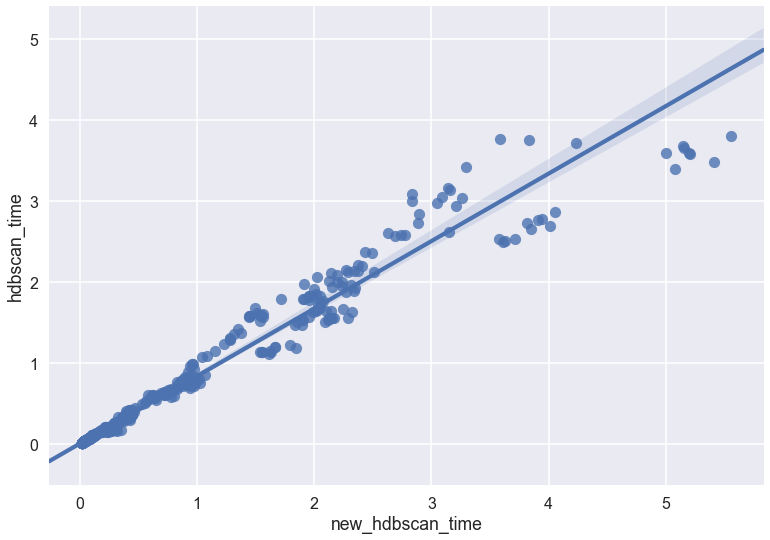

In [13]:
sns.regplot(results.new_hdbscan_time, results.hdbscan_time,robust=True)

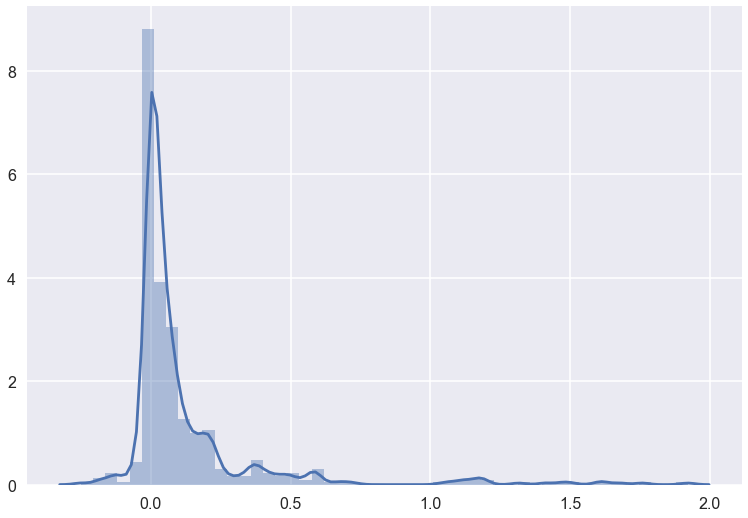

In [14]:
sns.distplot(results.new_hdbscan_time - results.hdbscan_time)

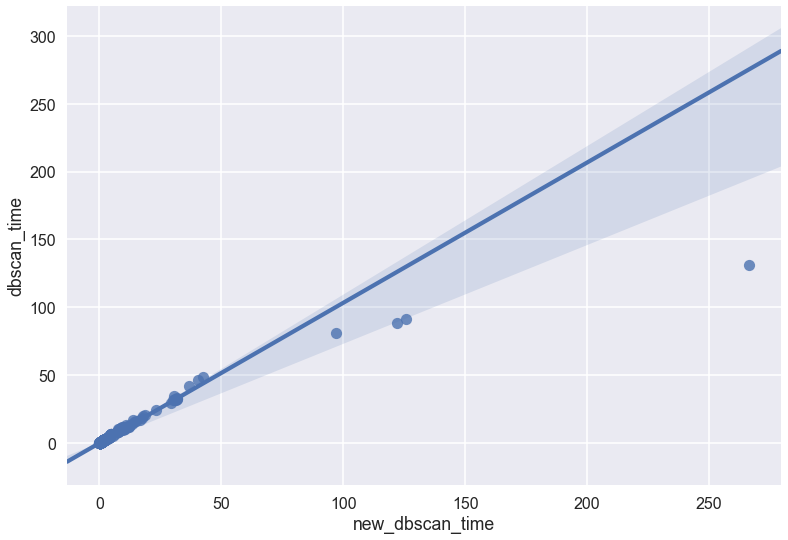

In [15]:
sns.regplot(results.new_dbscan_time, results.dbscan_time,robust=True)

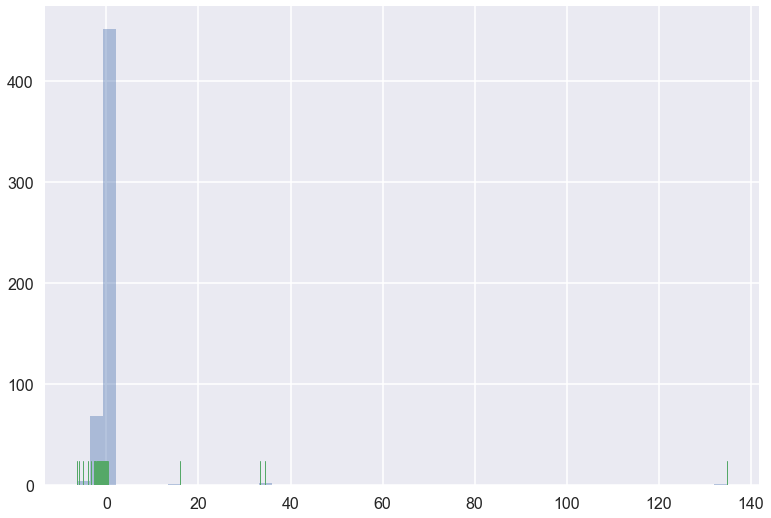

In [16]:
sns.distplot(results.new_dbscan_time - results.dbscan_time, rug=True,rug_kws={"color": "g"},kde=False)

Though the hdbscan timings are comparible between the laptop and large memory cluster that is not true for the larger dbscan runs where we likely observe the effects of exceeding the physical memory on our laptop.   Due to these problems we will use the benchmark results generated during the initial paramters search on our large memory computer.

## Run time comparison of DBSCAN and HDBSCAN*
### Restructure the data
We created the original data frame so we could examine the pairwise adjusted rand index between clusterings.  To be able to plot the results we will need to restructure our data to have a single time variable and a seperate variable indicating which algorithm we ran.  This should double the the number of rows in our data frame.

In [17]:
results_dbscan = pd.DataFrame({'size':optResults['size'], 'dimension': optResults.dimension, 'clusters': optResults.clusters, 
                               'rep':optResults.rep, 'time':optResults.dbscan_time, 'algorithm':'dbscan'
                            })
results_hdbscan = pd.DataFrame({'size':optResults['size'], 'dimension': optResults.dimension, 'clusters': optResults.clusters, 
                                'rep':optResults.rep, 'time':optResults.hdbscan_time, 'algorithm':'hdbscan'
                            })
toPlot = pd.concat([results_dbscan, results_hdbscan], ignore_index=True)
 

In [18]:
toPlot.head()

,algorithm,clusters,dimension,rep,size,time
0,dbscan,2,50,1,256000,11767.077296
1,dbscan,2,2,1,512000,4.252407
2,dbscan,10,2,1,512000,4.467593
3,dbscan,2,10,1,512000,18877.248985
4,dbscan,10,50,1,512000,10044.110780


We use log-log plots to better illustrate the scaling of the experiments.

In [19]:
toPlot.time = np.log10(toPlot.time)
toPlot['size'] = np.log10(toPlot['size'])

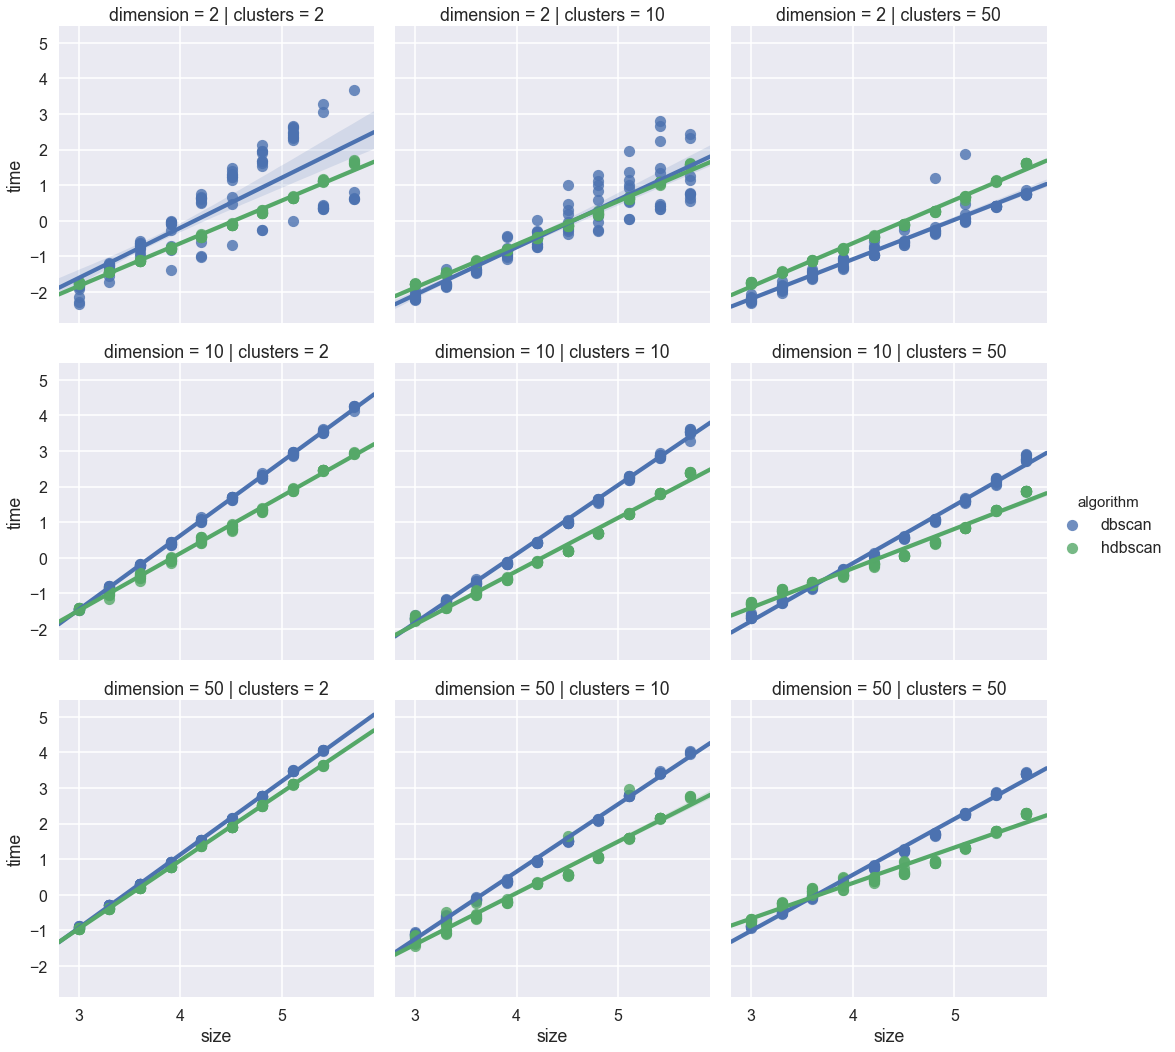

In [20]:
a= sns.lmplot(x = 'size', y='time', hue='algorithm', col='clusters', row='dimension', data=toPlot)

The above plot shows that hdbscan is clearly competitite with dbscan in terms of scalabiltiy across the data sets in question.  

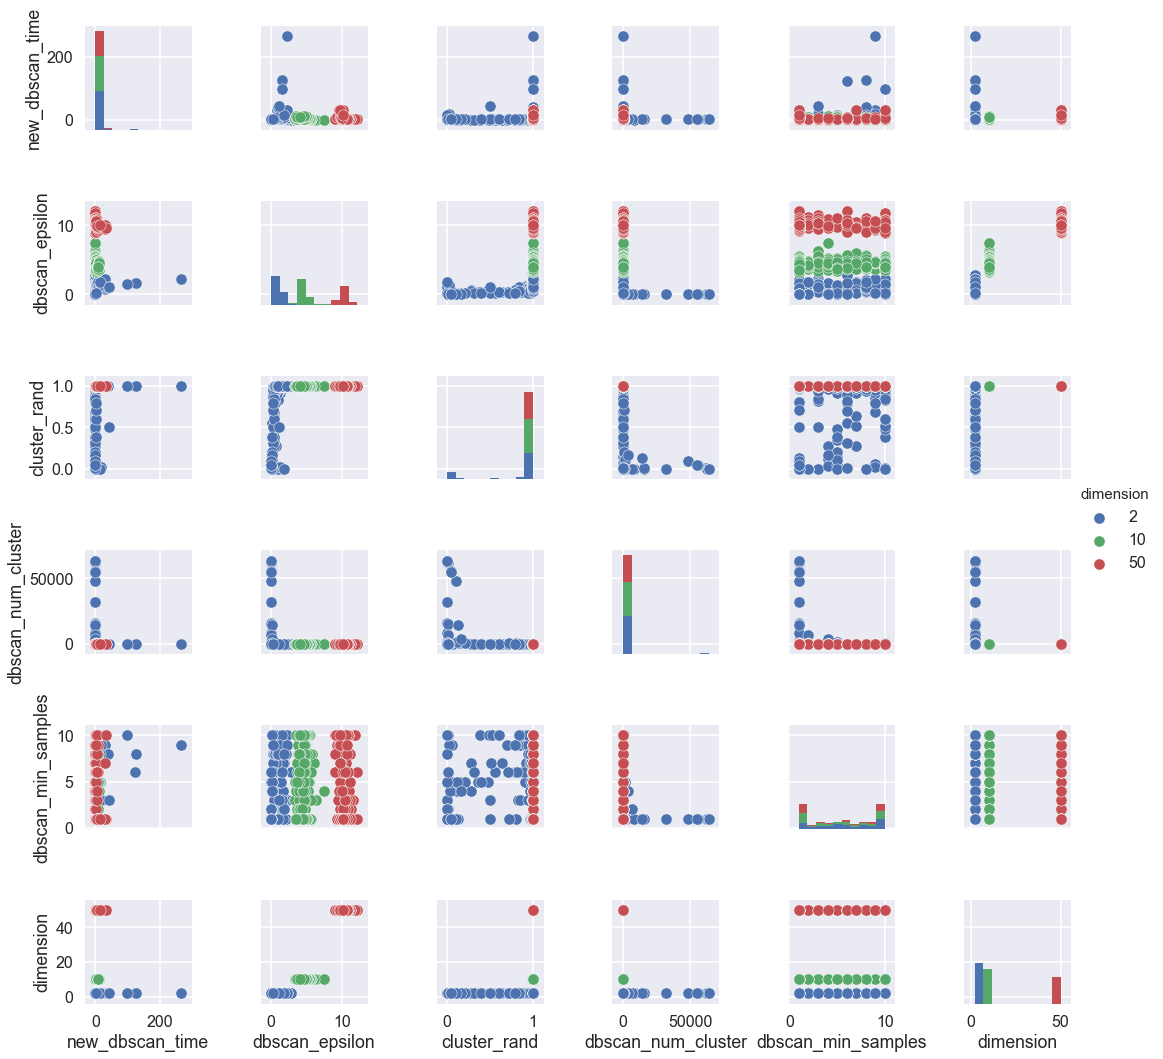

In [21]:
dbscan_behavour = (results[['new_dbscan_time', 'dbscan_epsilon', 'cluster_rand', 'dbscan_num_cluster', 'dbscan_min_samples','dimension']])
sns.pairplot(dbscan_behavour,hue='dimension')

In [22]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
seed,528.0,431.558712,259.849096,0.000000,204.750000,434.500000,656.250000,869.000000
size,528.0,13405.303030,18064.152239,1000.000000,2000.000000,4000.000000,16000.000000,128000.000000
dimension,528.0,17.257576,19.794627,2.000000,2.000000,10.000000,50.000000,50.000000
clusters,528.0,22.287879,21.207041,2.000000,2.000000,10.000000,50.000000,50.000000
rep,528.0,4.496212,2.881595,0.000000,2.000000,4.500000,7.000000,9.000000
hdbscan_time,528.0,0.696903,0.879406,0.016181,0.076024,0.309354,0.897378,3.797454
dbscan_time,528.0,3.405922,10.527213,0.004488,0.066132,0.320831,2.254727,131.520589
adjusted_rand,528.0,0.901996,0.255868,0.000000,0.995023,1.000000,1.000000,1.000000
hdbscan_min_samples,528.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000
hdbscan_min_cluster_size,528.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Cluster comparison
In our experiment we optimize paramters of dbscan with respect to matching the cluster results of an hdbscan run. To do this we make use of the adjusted rand index. It should be noted that both dbscan and hdbscan are not partitioning algorithms and that the adjusted rand index is defined for partitionings of data points.  This requires that one decides how to treat background points (outliers).  The two natural options are to simply pass the cluster results directly to adjusted_rand.  This presumes that all background points should be treated as a single cluster (coded as a -1).  This would boost the adjusted rand score of clustering which agree on their background noise (even if they agree on no other clusters).  The alternative is what is referred to below as cluster_rand where background points are treated as each belonging to their own cluster this focusses on agreement amongst identified clusters and ignores agreement or disagreements among outlier points.

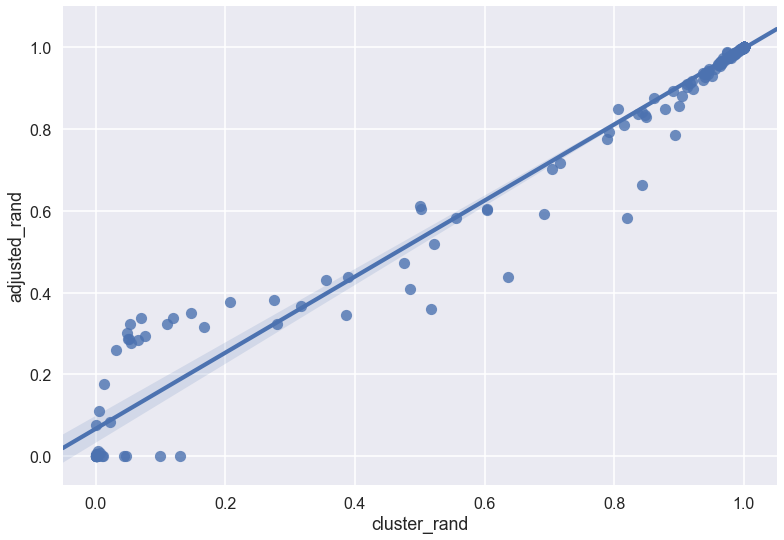

In [23]:
sns.regplot('cluster_rand','adjusted_rand', data=results)

Here we can see that there is a strong correlation between the two versions of our rand index.

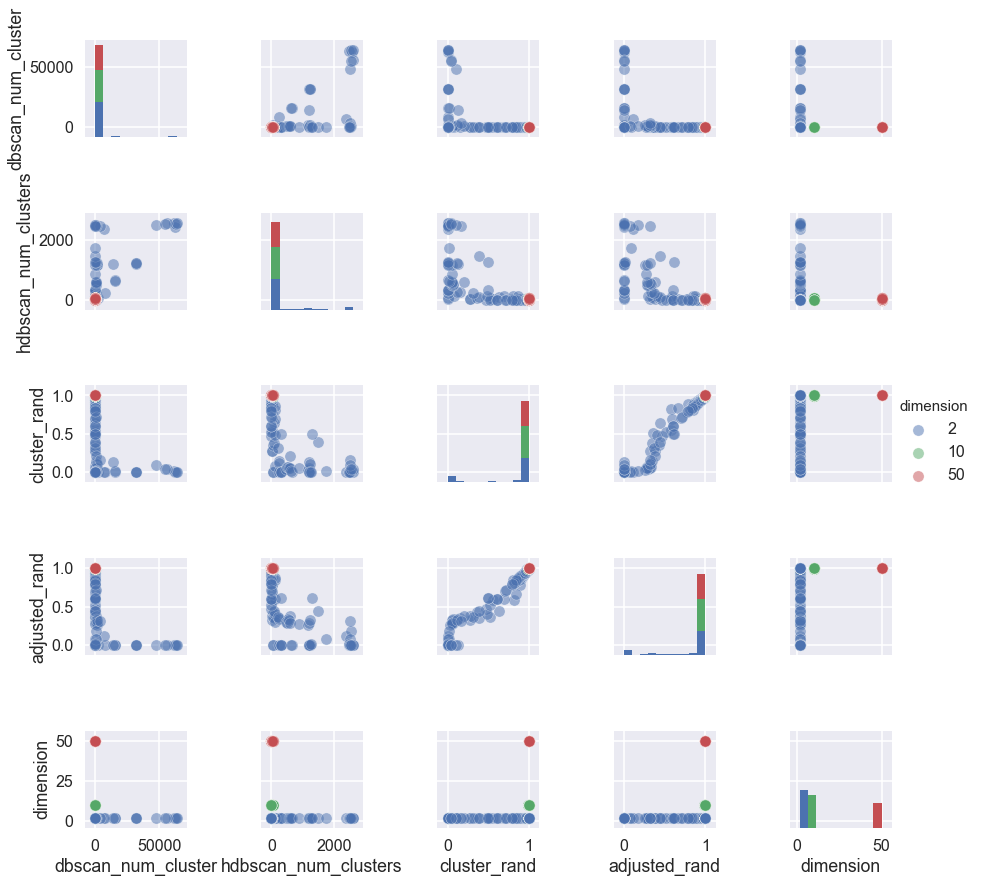

In [24]:
comparison_behavour = (results[['dbscan_num_cluster', 'hdbscan_num_clusters', 'cluster_rand', 'adjusted_rand', 'dimension']])
sns.pairplot(comparison_behavour,hue='dimension',plot_kws={'alpha':0.5})

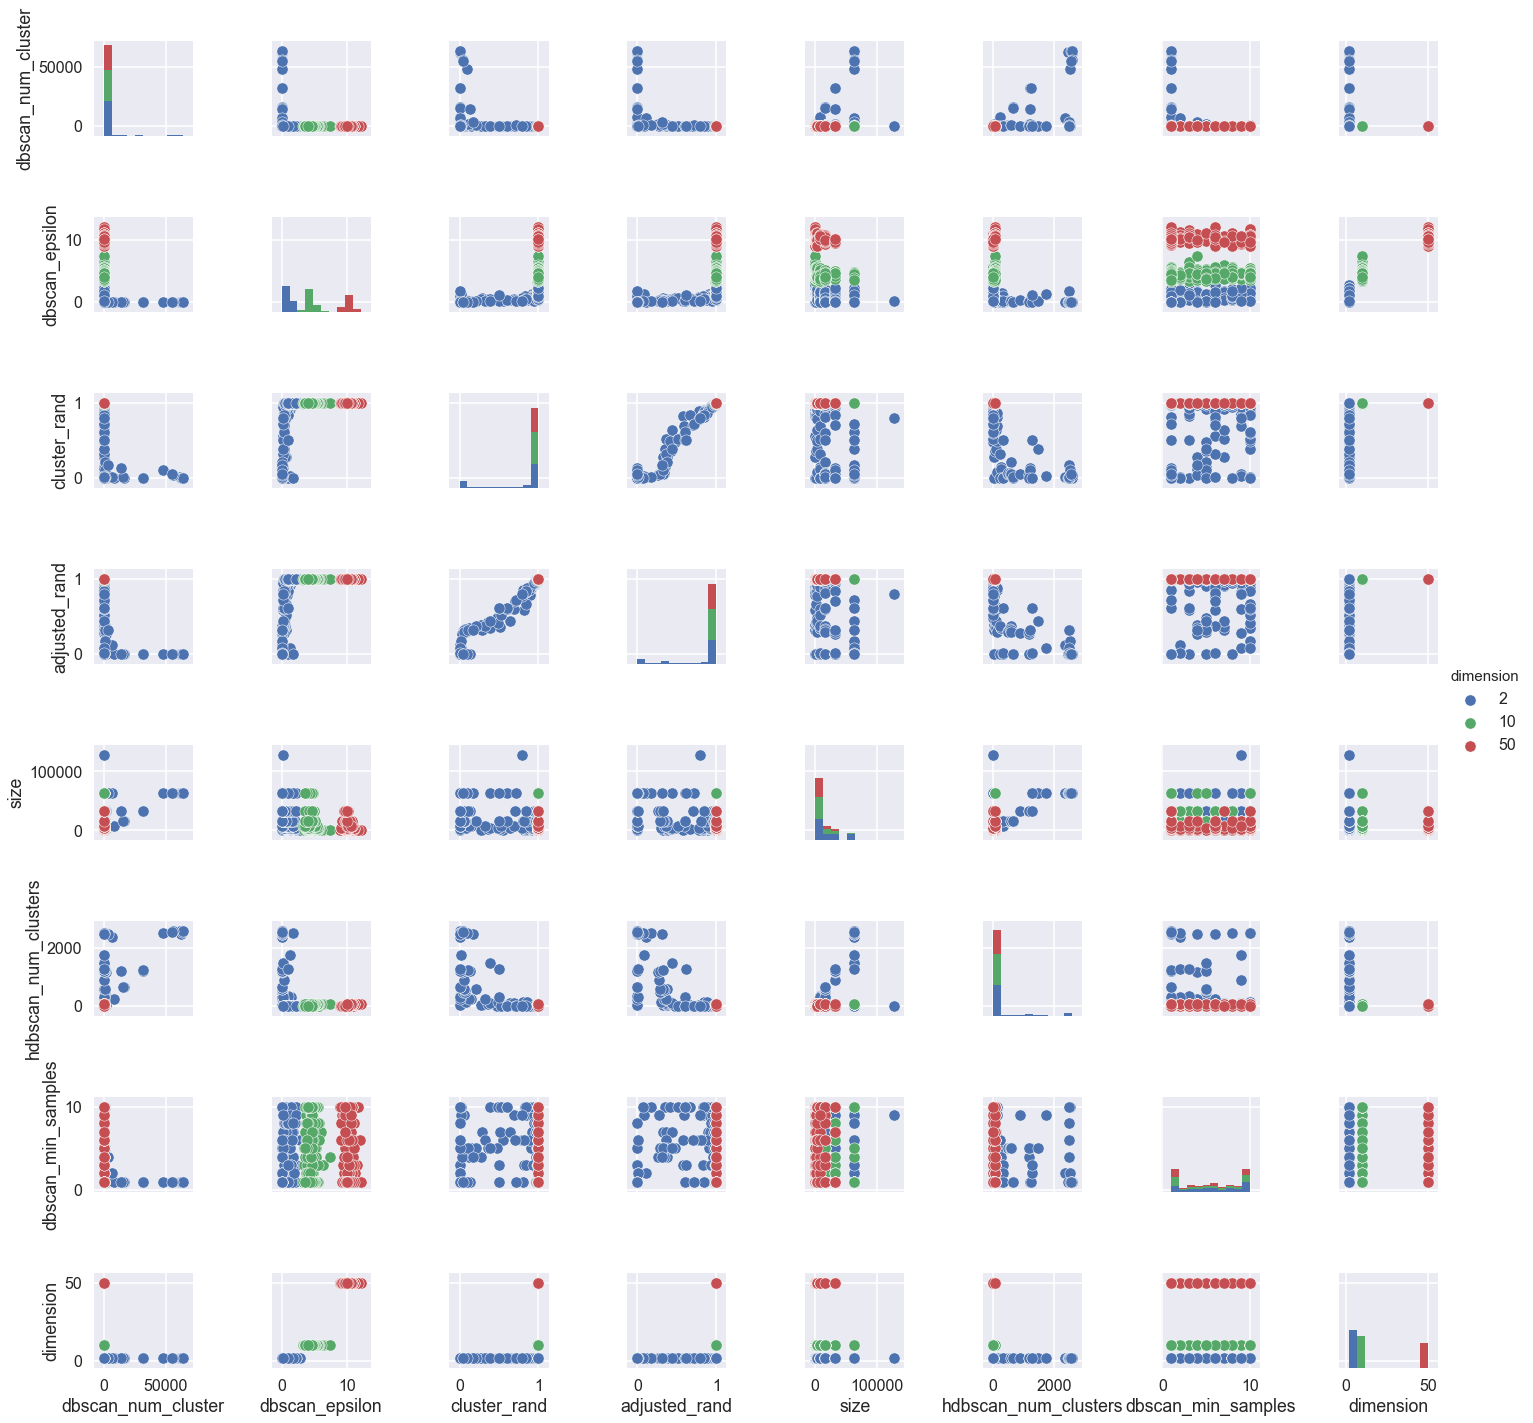

In [25]:
comparison_behavour = (results[['dbscan_num_cluster', 'dbscan_epsilon', 'cluster_rand', 'adjusted_rand', 'size','hdbscan_num_clusters', 'dbscan_min_samples','dimension']])
sns.pairplot(comparison_behavour,hue='dimension')

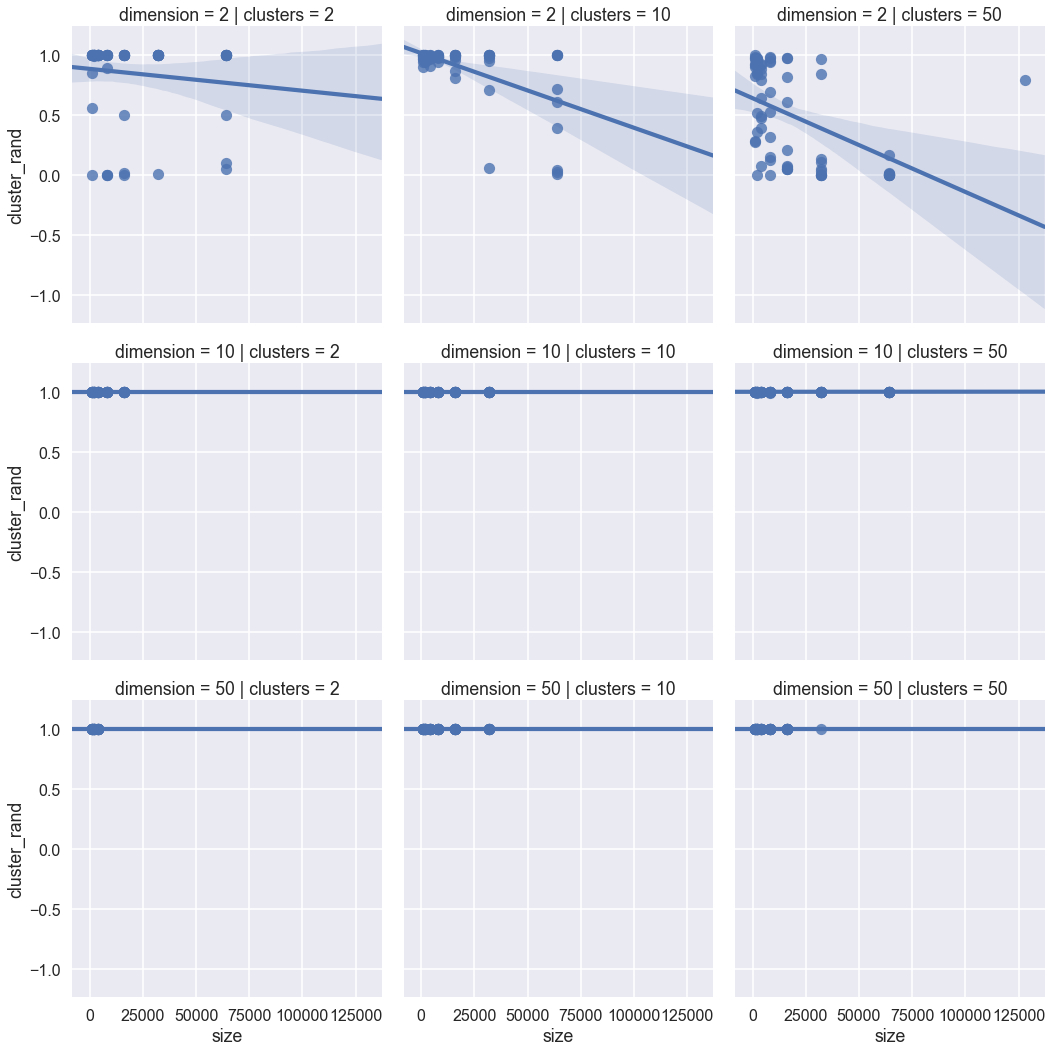

In [26]:
sns.lmplot(x = 'size', y='cluster_rand', col='clusters', row='dimension', data=results)

HDBSCAN when run with default parameters will refuse to return a single cluster (to alter this behaviour use the parameter allow_single_cluster=True).  For larger amounts of data in two dimensional space we are more liklely to get overalpping Gaussians.  In this case when HDBSCAN is forced to select multiple clusters it pulls out the many small pockets of denser data within our Gaussians.  These are inevitably variable density clusters which DBSCAN is unable to replicate well.  This leads to some very low rand index values between our hdbscan and dbscan results when this occurs in a two dimensional space.



## Step by step walkthrough of the process

### Data


Though we are building a generative model to compare DBSCAN and HDBSCAN*s performance it should be noted that we are comparing the clustering results of or algorithms directly against each other and not against the underlying generative model.  This is intentional, since for any given instantiation of our generative model the generative model is not necessary the most likely model.  Thus, we avoid this issue entirely by ignoring the generative model used in these experiments.

### Let's get an experiment

In [27]:
results[(results.adjusted_rand < 0.5) & (results.dimension==2)]

,seed,size,dimension,clusters,rep,hdbscan_time,dbscan_time,adjusted_rand,hdbscan_min_samples,hdbscan_min_cluster_size,dbscan_epsilon,dbscan_min_samples,dbscan_num_cluster,hdbscan_num_clusters,cluster_rand,new_hdbscan_time,new_dbscan_time
21,452.0,1000,2,50,5.0,0.018056,0.005152,0.323758,5.0,5.0,0.672873,7.0,23.0,25.0,0.279732,0.020509,0.004730
28,722.0,1000,2,50,8.0,0.018691,0.004874,0.380978,5.0,5.0,0.435029,4.0,60.0,35.0,0.274940,0.020825,0.004395
32,450.0,1000,2,2,5.0,0.018961,0.004488,0.000025,5.0,5.0,0.005592,1.0,996.0,37.0,0.001035,0.019678,0.004951
50,101.0,2000,2,50,1.0,0.034542,0.011426,0.360471,5.0,5.0,0.503761,7.0,33.0,45.0,0.516822,0.037679,0.010583
55,641.0,2000,2,50,7.0,0.035370,0.010616,0.429698,5.0,5.0,0.389575,5.0,83.0,55.0,0.354949,0.037966,0.009234
81,821.0,2000,2,50,9.0,0.038514,0.009507,0.000017,5.0,5.0,0.010892,1.0,1996.0,41.0,0.000058,0.040919,0.009331
117,830.0,4000,2,50,9.0,0.072521,0.030958,0.473309,5.0,5.0,0.555659,5.0,9.0,5.0,0.475972,0.080889,0.030463
121,20.0,4000,2,50,0.0,0.073600,0.026066,0.344537,5.0,5.0,0.398529,10.0,39.0,93.0,0.386636,0.085048,0.023409
128,110.0,4000,2,50,1.0,0.075065,0.023505,0.408502,5.0,5.0,0.380502,10.0,67.0,120.0,0.485544,0.082048,0.022599
129,560.0,4000,2,50,6.0,0.075598,0.023914,0.292961,5.0,5.0,0.267769,5.0,139.0,115.0,0.076072,0.079115,0.025063


Select an experiment with interesting results and recreate the data using the appropriate seed

In [35]:
instance = results.ix[21]
size=np.int(instance['size'])
dataset_dimension=np.int(instance.dimension)
dataset_n_clusters=np.int(instance.clusters)
data, data_labels = sklearn.datasets.make_blobs(n_samples=size, 
                                           n_features=dataset_dimension, 
                                           centers=dataset_n_clusters,random_state=np.int(instance.seed))
data.shape

(1000, 2)

### HDBSCAN model 

Build the hdbscan model and time it.  

In [36]:
hdbscan_min_samples = 5
hdbscan_min_cluster_size = 5

In [37]:
start = timer()
labels = hdbscan.HDBSCAN(min_samples=hdbscan_min_samples, 
                                min_cluster_size=hdbscan_min_cluster_size).fit_predict(data)
end = timer()
print(end - start)

0.024677962064743042


Have a look at the adjusted rand score and the cluster adjusted rand score (described previously) between the hdbscan results and the 'true' labels.  

In [38]:
def relabelOutliers(labels):
    """
    Args:
    labels (array of ints): output list of cluster id's (e.g. from hdbscan or dbscan) with outliers labeled as -1
    Returns:
    array of ints: an array corresponding to labels with each -1 relabeled to a one up number greater than
    the previous arrays max value.
    This has the effect of allocating each outlier to it's own cluster
    """
    lab = labels
    lab[lab==-1] = list(range(sum(lab==-1)))+max(lab)
    return(lab)
                        

def clusterAdjustedRandScore(labels1, labels2):
    """
    This assumes that outlier points will be labelled with -1.  
    These points should be considered to lie each within their own cluster
    and not be treated as being a single large background cluster.  
    We relabel background points before computing the standard adjusted rand index.d
    """
    return(sklearn.metrics.adjusted_rand_score(relabelOutliers(labels1), relabelOutliers(labels2)))

In [39]:
sklearn.metrics.adjusted_rand_score(labels, data_labels)

0.079297254521297003

In [40]:
clusterAdjustedRandScore(labels, data_labels)

0.18165911736058982

### Look at your data
That is if you have 2 dimensional data look at it.  Otherwise, do some dimension reduction first.

#### Coloured by the genertiive model

Warning: This isn't true clustering.  It's just the generative model.

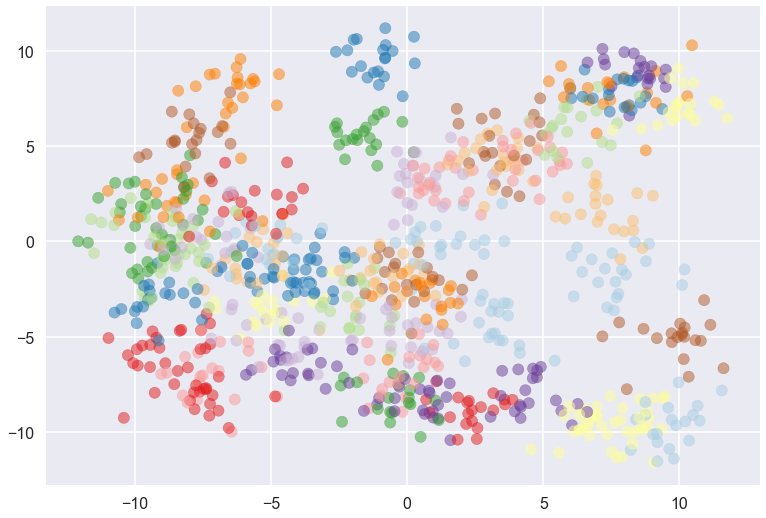

In [47]:
pal = sns.color_palette('Paired', np.max(data_labels) + 1)
color = [pal[x] if x >= 0 else (0.5, 0.5, 0.5) for x in data_labels]
plt.scatter(*data.T, c=color, alpha=0.5)

#### Coloured by HDBSCAN\*

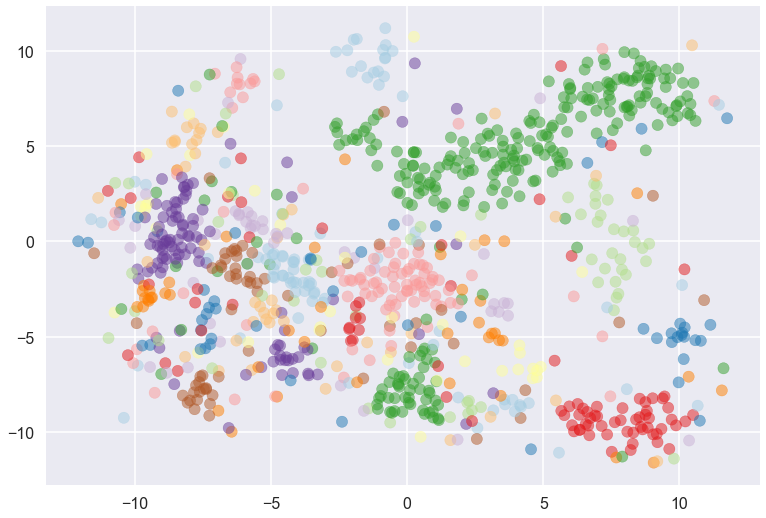

In [41]:
pal = sns.color_palette('Paired', np.max(labels) + 1)
color = [pal[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]
plt.scatter(*data.T, c=color, alpha=0.5)

### DBSCAN results

In [42]:
instance.dbscan_epsilon

0.67287269646500003

In [43]:
dbscan_labels = sklearn.cluster.DBSCAN(eps=instance.dbscan_epsilon, min_samples= instance.dbscan_min_samples).fit_predict(data)

In [44]:
sklearn.metrics.adjusted_rand_score(labels, dbscan_labels)

0.098467441548476725

In [45]:
clusterAdjustedRandScore(labels, dbscan_labels)

0.27973167132874116

#### Coloured by DBSCAN

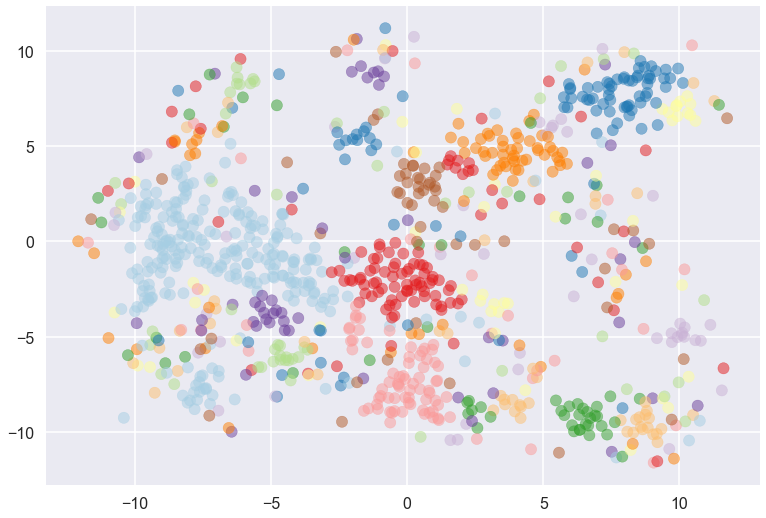

In [46]:
pal = sns.color_palette('Paired', np.max(dbscan_labels) + 1)
color = [pal[x] if x >= 0 else (0.5, 0.5, 0.5) for x in dbscan_labels]
plt.scatter(*data.T, c=color, alpha=0.5)